In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import providers
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
df = pd.read_csv('BTumor.csv')
df.head(8)

,Unnamed: 0,X53416,M83670,X90908,M97496,X90908.1,U37019,R48602,T96548,X64559,...,H87456,R64130,H11125.1,U22055,L22524,M13699.1,X54489,T55008,M10065.2,y
0,0,70,-81,25,10,22,113,36,163,9,...,75,5,68,138,53,-4,123,2,19,tumor
1,1,108,-30,-7,60,0,24,8,113,-3,...,186,6,60,93,140,-3,271,-1,-51,tumor
2,2,75,-1,5,48,6,34,27,35,-1,...,186,225,94,62,39,-14,127,7,192,tumor
3,3,871,4,14,78,-6,85,65,227,19,...,77,6,78,30,87,-4,59,3,367,tumor
4,4,-92,-34,14,19,11,-6,27,-8,9,...,87,303,204,81,105,9,265,-2,126,tumor
5,5,21,-13,5,11,-18,78,4,143,14,...,51,3,131,38,10,4,3,9,145,tumor
6,6,225,118,-5,175,-40,108,54,272,32,...,64,-3,142,55,202,-23,110,7,-14,tumor
7,7,-346,-35,37,42,39,18,14,28,34,...,84,-5,13,102,27,17,30,-5,-53,tumor


In [3]:
f_name_list = list(df)
list(f_name_list)

['Unnamed: 0',
 'X53416',
 'M83670',
 'X90908',
 'M97496',
 'X90908.1',
 'U37019',
 'R48602',
 'T96548',
 'X64559',
 'T55741',
 'T64171',
 'T54547',
 'M95936',
 'X54162',
 'H57136',
 'M10373',
 'T55200',
 'T46924',
 'L11708',
 'M18079',
 'T46933',
 'M98331',
 'H54425',
 'M76378',
 'M26393',
 'H59796',
 'M82962',
 'T55255',
 'L13773',
 'X53416.1',
 'M63391',
 'M63603',
 'R33881',
 'M95787',
 'J03037',
 'J02854',
 'H37925',
 'M83186',
 'T72257',
 'M84526',
 'T76971',
 'H77597',
 'T67986',
 'R99208',
 'M22324',
 'U03749',
 'T63266',
 'R93176',
 'U14528',
 'L02785',
 'R94967',
 'J03037.1',
 'M74509',
 'L11708.1',
 'X77777',
 'M16707',
 'R69552',
 'M76378.1',
 'X63597',
 'R50730',
 'M76378.2',
 'R87126',
 'H43887',
 'L08010',
 'R28373',
 'D00003',
 'T92451',
 'U17077',
 'U25138',
 'X86693',
 'H57136.1',
 'X73502',
 'J03037.2',
 'R70806',
 'T51913',
 'M64110',
 'T50678',
 'Z50753',
 'H45474',
 'M58286',
 'U08854',
 'M16451',
 'X52679',
 'X15882',
 'D45370',
 'T71025',
 'M12272',
 'M26683',
 

In [4]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [5]:
clean_data['y'].replace(to_replace='tumor', value=1, inplace=True)
clean_data['y'].replace(to_replace='Normal', value=0, inplace=True)

In [29]:
clean_data = clean_data.drop('Unnamed: 0', axis=1)
x_org = clean_data.drop('y', axis=1)
cat = clean_data.y

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [30]:
print(rel.feature_importances_)

[0.         0.00714286 0.         ... 0.         0.         0.        ]


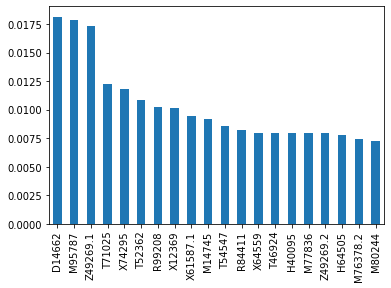

In [31]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [33]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [34]:
ordered_f.head(10)

M97496    0.707229
R36977    0.688710
T96548    0.680840
M77836    0.650747
Z50753    0.649017
M83670    0.643803
H20426    0.639699
T64297    0.630035
U17077    0.624524
R08183    0.609699
dtype: float64

In [36]:
test_ratio = 0.2
seed = 1984
np.random.seed(seed)
selected_f = clean_data[['M97496','R36977','T96548','Z50753','M83670','M77836','J03037.2','T64297','U17077','y']]
x_org = np.array(selected_f.drop('y', axis =1))
cat = np.array(selected_f.y)
x = preprocessing.normalize(x_org, axis=0)
x_train, x_test, y_train, y_test = train_test_split(x, cat, test_size=test_ratio, random_state=seed, stratify=cat)

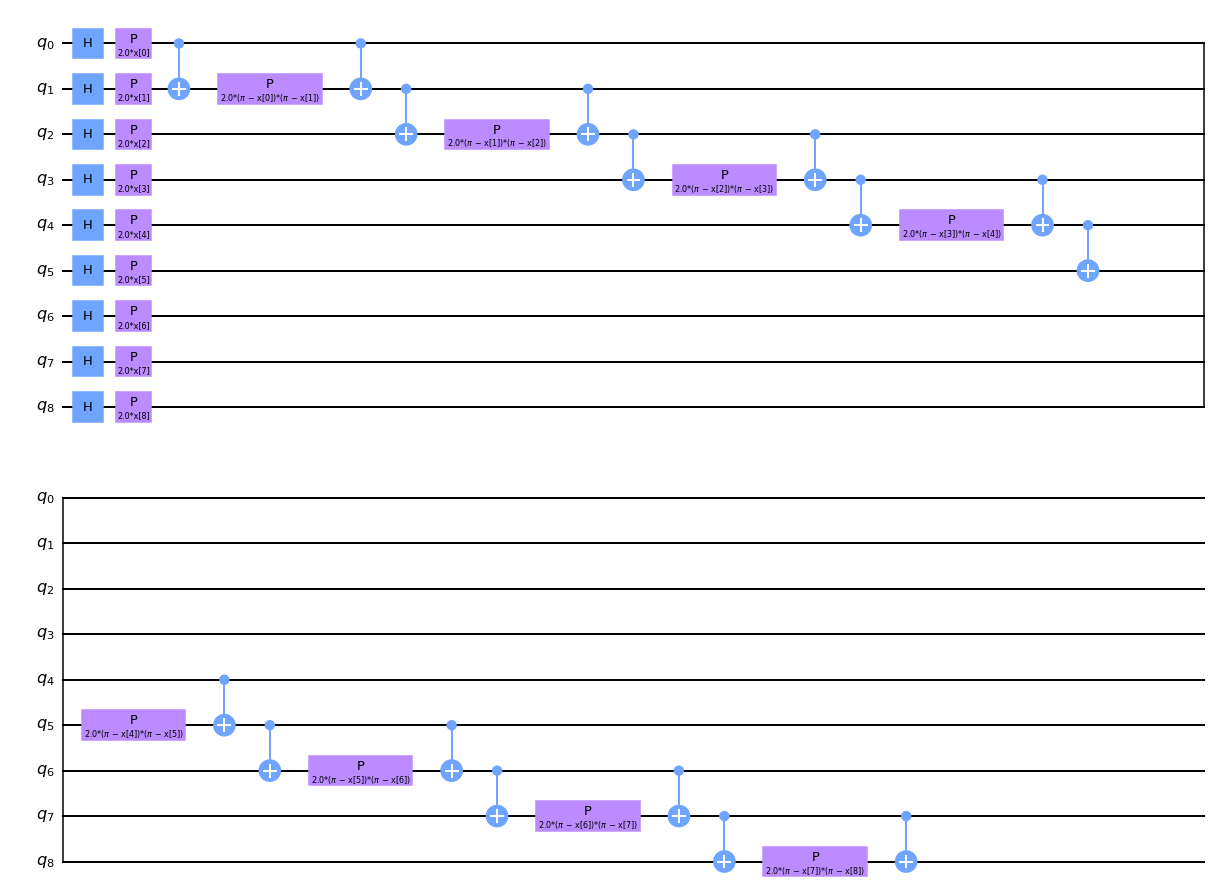

In [37]:
feature_dim = x.shape[1]
feature_map_layer = 1
ent = 'linear'

fmap = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_layer, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

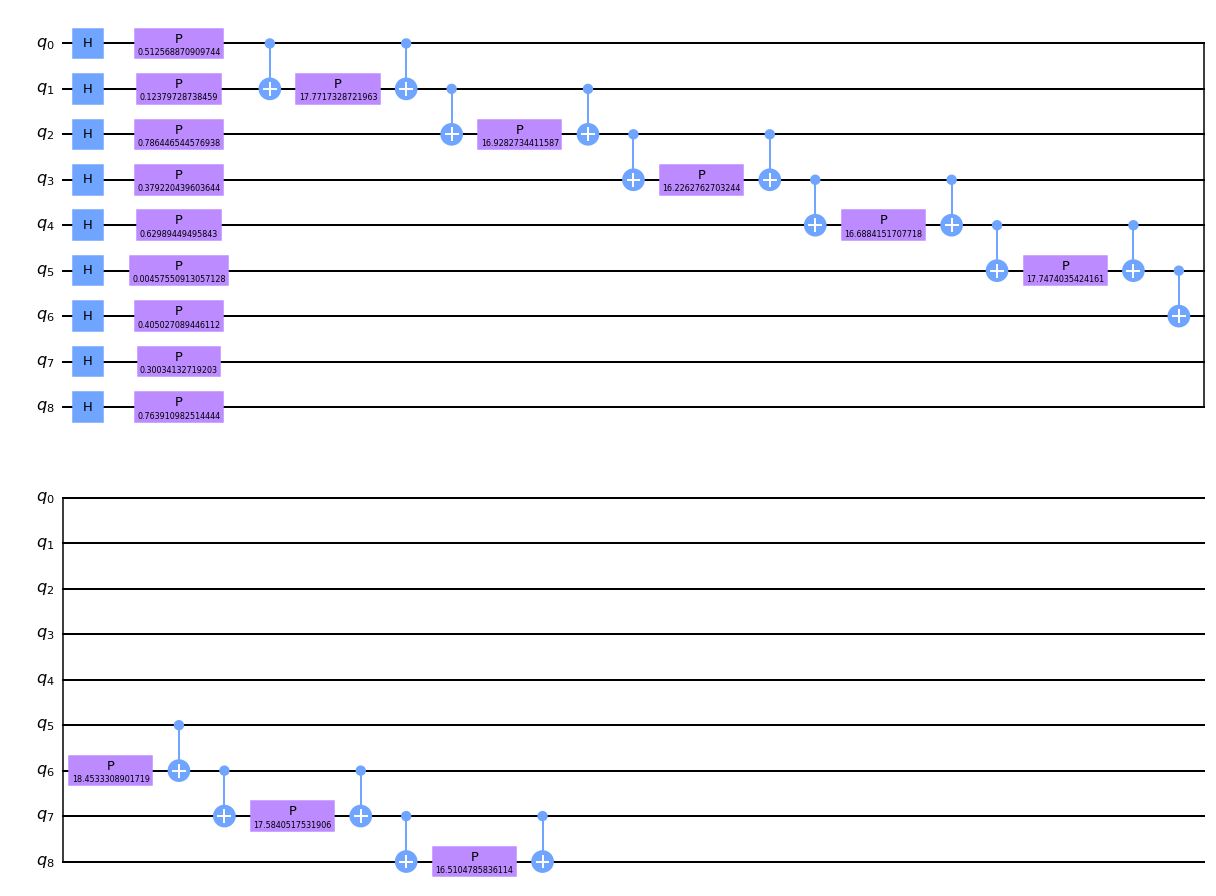

In [38]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

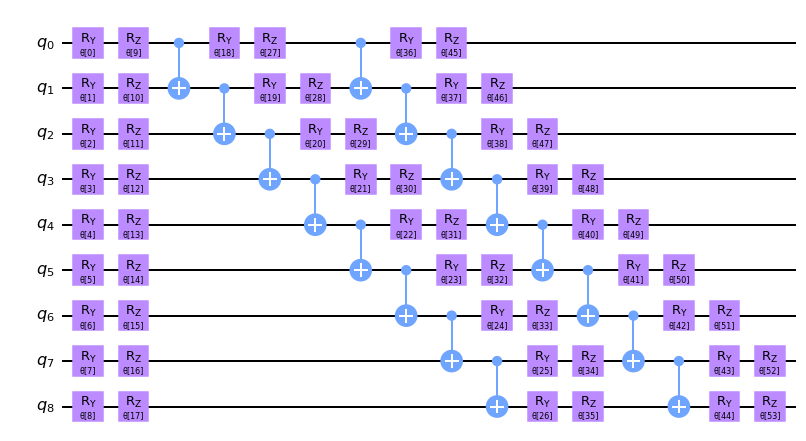

In [39]:
rotations = ['ry', 'rz']
var_form_rep = 2

ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
ansatz_tl.decompose().draw('mpl', scale=1)

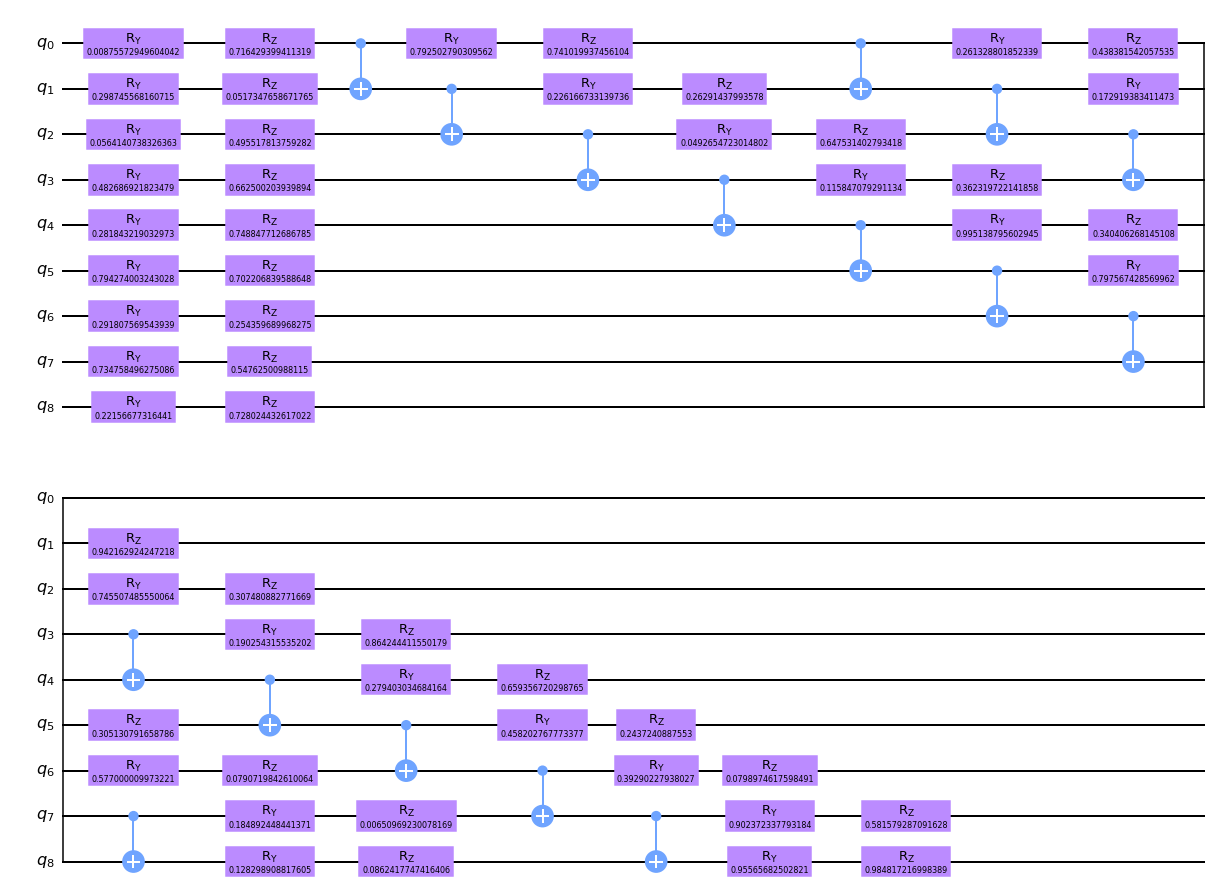

In [40]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=1)

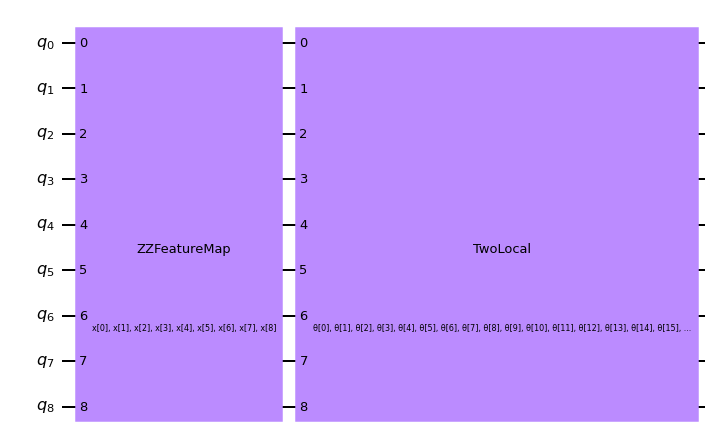

In [41]:
var_circuit = fmap.compose(ansatz_tl)
var_circuit.draw('mpl')

In [42]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [43]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [45]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [46]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.52539062, 0.47460938]])

In [47]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-1.44531250e-01, -2.85888672e-01,  2.51464844e-02,
          6.10351563e-03,  1.56250000e-02, -9.52148438e-03,
         -1.04980469e-02,  1.70898437e-03,  1.07421875e-02,
         -1.56250000e-01,  1.29394531e-02, -3.17382812e-03,
         -4.88281250e-04, -5.85937500e-03, -9.52148438e-03,
         -2.19726563e-03,  0.00000000e+00, -5.12695312e-03,
         -7.73925781e-02, -1.36718750e-02,  2.92968750e-03,
          7.32421875e-03, -3.17382813e-03,  3.66210938e-03,
         -3.41796875e-03, -1.22070313e-03,  1.22070312e-03,
         -1.56250000e-02, -4.80957031e-02, -9.27734375e-03,
          1.73339844e-02,  7.56835938e-03, -3.17382812e-03,
          8.30078125e-03, -2.68554688e-03, -8.30078125e-03,
          2.30468750e-01, -8.78906250e-03, -7.32421875e-04,
          2.68554687e-03,  1.80664062e-02,  6.83593750e-03,
          1.95312500e-03,  6.83593750e-03,  1.12304688e-02,
         -9.76562500e-04, -4.88281250e-03,  8.30078125e-03,
          9.76562500e-03,  4.88281250e-0

In [48]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [49]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [50]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


# x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])
# x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test])

vqc = vqc.fit(x_train, y_train_1h)

3 - 24.91173294210272
6 - 25.45799257073424
9 - 25.300948988959448
12 - 24.55472393658492
15 - 24.617375247289
18 - 24.48386641119623
21 - 24.238325502288312
24 - 24.30694550083616
27 - 23.52798948447433
30 - 23.508908438549213
33 - 23.805667910089426
36 - 23.461137352271372
39 - 23.53365021706076
42 - 23.225367945691488
45 - 23.27920128842542
48 - 23.127387007301046
51 - 23.077887706942725
54 - 23.09478208748376
57 - 23.004877041193225
60 - 22.505492506580737
63 - 22.308684433198767
66 - 22.314375194629992
69 - 22.542815752041125
72 - 22.66290751612806
75 - 22.433527758465505
78 - 22.16825319441939
81 - 22.207579030771903
84 - 22.03389819210884
87 - 21.79522950899613
90 - 21.848347342602185
93 - 21.687270074713375
96 - 21.46188696160474
99 - 21.839208866374616
102 - 21.546935562259645
105 - 21.607471619418135
108 - 21.689128473874664
111 - 21.74291999470976
114 - 21.675054972352605
117 - 21.74307501091523
120 - 21.44811144064454
123 - 21.30108593454353
126 - 21.30650673450041
129 - 21

In [51]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.6785714285714286
Score on the test set 0.875


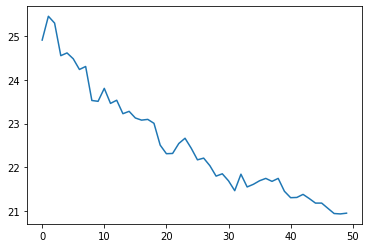

In [52]:
plt.plot(loss_recorder)